In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import json

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
print (df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocess(text):
    text = re.sub(r'<.*?>', '', text)
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    processed_tokens = []
    negation = False
    for word in tokens:
        if word in ['not', 'never']:
            negation = True
        elif word.isalpha() and word not in stop_words:
            if negation:
                word = 'not_' + word  
                negation = False
            word = lemmatizer.lemmatize(word)  
            processed_tokens.append(word)
        else:
            negation = False
    return ' '.join(processed_tokens)

print('\n\nStarting Preprocessing')
df['review'] = df['review'].apply(preprocess)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print('\n\nFinished Preprocessing')



Starting Preprocessing


Finished Preprocessing


In [5]:
print(df.head())

                                              review  sentiment
0  one reviewer mentioned watching oz episode hoo...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically family little boy jake think zombie ...          0
4  petter mattei love time money visually stunnin...          1


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], random_state = 0, test_size=0.15)

In [7]:
'''
this cell is very computationally taxing due to it running 720 combinations 5 times each, totalling in 3600 fits
if you need to run it to see if it works, i'd recommend deleting the n_jobs= -1 flag as it will use all resources on your computer, making it difficult to stop execution
'''

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('lr', LogisticRegression(max_iter=1000, solver='saga'))
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'tfidf__max_features': [5000, 10000, None],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2', 'l1', 'elasticnet', None], 
    'lr__l1_ratio': [0.2, 0.5, 0.8]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, error_score='raise')
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


KeyboardInterrupt: 

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print('Optimized Model Accuracy:' accuracy)
print(classification_report(y_test, predictions))
print('AUC score:', roc_auc_score(y_test, predictions))
with open('bestparameters_LR-HP.json', 'w') as file:
    json.dump(best_parameters, file)

In [7]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1, 5))
x_train_vectorised = vect.fit_transform(x_train)
x_test_vectorised = vect.transform(x_test)

models = {
    'MultinomialNB': MultinomialNB(alpha=0.1),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier()
}

def model_experiment(models, x_train, y_train, x_test, y_test):
    for name, model in models.items():
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        accuracy = accuracy_score(y_test, predictions)
        print(name, 'Accuracy:', accuracy)
        print(classification_report(y_test, predictions))
        print('AUC score:', roc_auc_score(y_test, predictions))
        print('\n')

model_experiment(models, x_train_vectorised, y_train, x_test_vectorised, y_test)

MultinomialNB Accuracy: 0.8832
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3796
           1       0.87      0.89      0.88      3704

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

AUC score: 0.8833296444819714


LogisticRegression Accuracy: 0.8932
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3796
           1       0.88      0.91      0.89      3704

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500

AUC score: 0.8933491432381931


SVC Accuracy: 0.9002666666666667
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3796
           1       0.89      0.91      0.90      3704

    accuracy      

In [8]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1, 4))
x_train_vectorised = vect.fit_transform(x_train)

model = LogisticRegression(C=10, penalty='l2', max_iter=1000) 

model.fit(x_train_vectorised, y_train)
x_test_vectorised = vect.transform(x_test)
predictions = model.predict(x_test_vectorised)

print('\n\n')
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)
print(classification_report(y_test, predictions))
print('AUC score is: ', roc_auc_score(y_test, predictions))




Accuracy: 0.9017333333333334
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3796
           1       0.89      0.91      0.90      3704

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500

AUC score is:  0.901837958337411


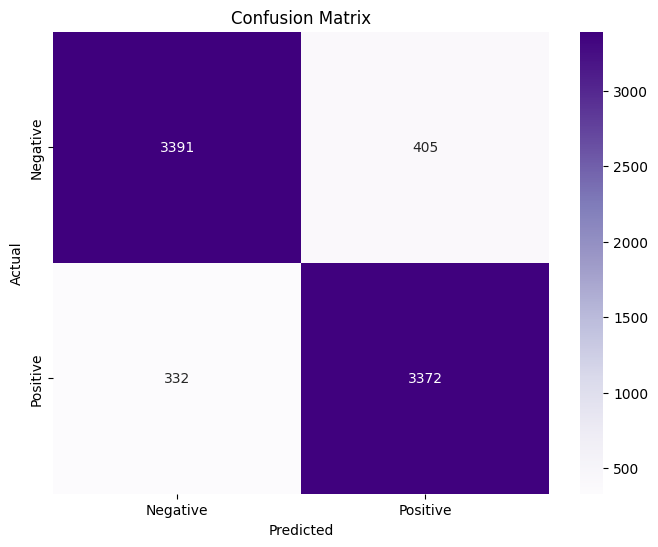

In [9]:
cm = confusion_matrix(y_test, predictions)
# Plotting using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


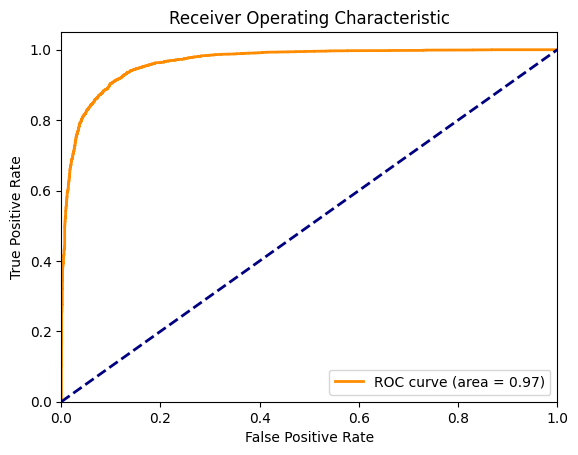

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test_vectorised)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<Axes: >

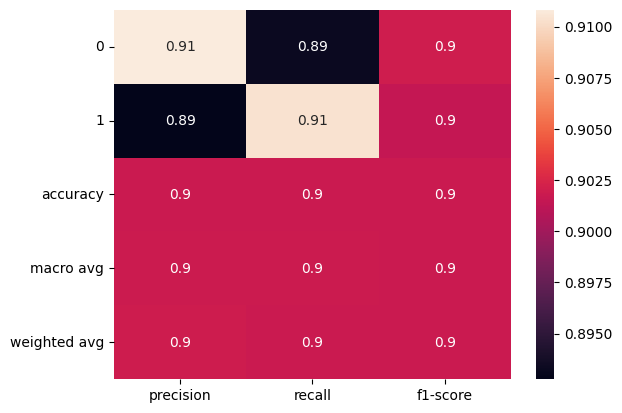

In [11]:
report = classification_report(y_test, predictions, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)